In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Activation, Dense,LSTM,Dropout
from sklearn.metrics import mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [3]:
# Database related all the code is moved to this file
%run -i "SqlConn.py"
#importing local py file
import SqlConn 

In [6]:
#Fetch Tweets and Sentiment data - Join from Tweet and Sentiment tables
try:
    df_dbFinanceData = SqlConn.fetchFinanceData("")
    print("Data transfer Done")
except BaseException as err:
    print(err)

Data transfer Done


In [7]:
df_dbFinanceData

,financeType,date,open,high,low,close,adjustedClose,volume
0,tesla,2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
1,tesla,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2,tesla,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
3,tesla,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
4,tesla,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...,...,...
6916,doge,2022-07-09,0.069224,0.070009,0.068995,0.069512,0.069512,254272147
6917,doge,2022-07-10,0.069509,0.069509,0.066533,0.067263,0.067263,299810124
6918,doge,2022-07-11,0.067268,0.067268,0.061535,0.061847,0.061847,326125900
6919,doge,2022-07-12,0.061851,0.062861,0.060087,0.060087,0.060087,298462083


In [8]:
tesla_price = df_dbFinanceData[df_dbFinanceData["financeType"] == "tesla"]

In [9]:
tesla_price

,financeType,date,open,high,low,close,adjustedClose,volume
0,tesla,2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
1,tesla,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2,tesla,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
3,tesla,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
4,tesla,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...,...,...
3025,tesla,2022-07-06,692.340027,703.690002,681.559998,695.200012,695.200012,23951200
3026,tesla,2022-07-07,701.760010,736.090027,696.630005,733.630005,733.630005,27310200
3027,tesla,2022-07-08,727.000000,764.940002,723.479980,752.289978,752.289978,33343700
3028,tesla,2022-07-11,756.309998,759.190002,700.880005,703.030029,703.030029,33080400


In [11]:
end_date = tesla_price['date'].iloc[-1]
end_date

'2022-07-12'

In [12]:
tesla_price['date'] = pd.to_datetime(tesla_price['date'], format='%Y-%m-%d')

SqlConn.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
tesla_price.dtypes

financeType              object
date             datetime64[ns]
open                    float64
high                    float64
low                     float64
close                   float64
adjustedClose           float64
volume                    int64
dtype: object

In [15]:
tesla_price.set_index("date",inplace = True)

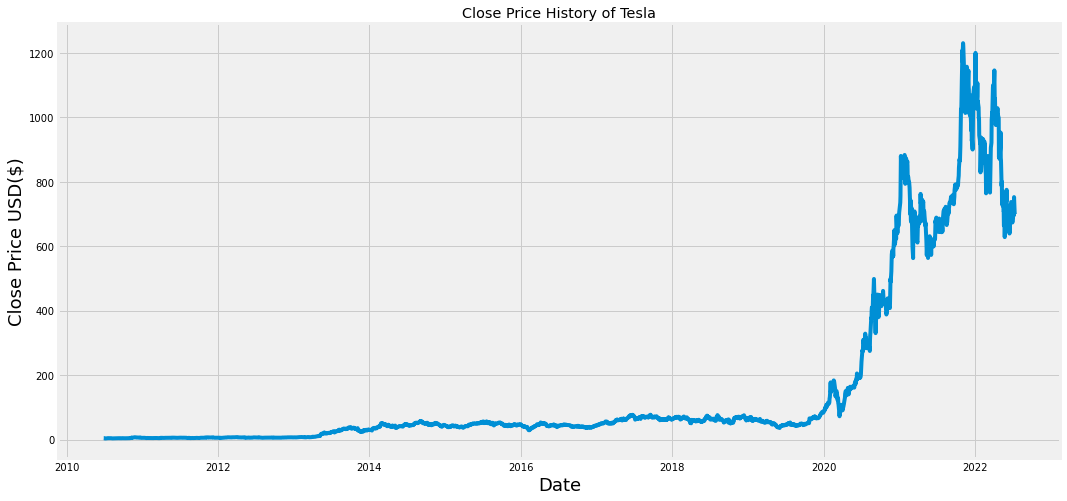

In [19]:
plt.figure(figsize=(16,8))
plt.title('Close Price History of Tesla')
plt.plot(tesla_price['close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD($)',fontsize=18)
plt.show()

In [53]:
data = tesla_price.drop(['financeType','open', 'high', 'low', 'adjustedClose', 'volume'], axis = 1)
price_column = 'close'
data.head()

,close
date,
2010-06-29,4.778
2010-06-30,4.766
2010-07-01,4.392
2010-07-02,3.840
2010-07-06,3.222


In [21]:
# This function splits the data in 70,30 ratio.
def train_test_split(df, test_size=0.3):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [22]:
train, test = train_test_split(data, test_size=0.2)

In [23]:
train.shape, test.shape

((2424, 1), (606, 1))

In [24]:
train

,close
date,
2010-06-29,4.778000
2010-06-30,4.766000
2010-07-01,4.392000
2010-07-02,3.840000
2010-07-06,3.222000
...,...
2020-02-07,149.613998
2020-02-10,154.255997
2020-02-11,154.876007


In [25]:
test

,close
date,
2020-02-14,160.005997
2020-02-18,171.679993
2020-02-19,183.483994
2020-02-20,179.882004
2020-02-21,180.199997
...,...
2022-07-06,695.200012
2022-07-07,733.630005
2022-07-08,752.289978


In [26]:
# Perform MinMax scaling
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(data).reshape(-1,1))
df1

array([[0.00131893],
       [0.00130915],
       [0.00100428],
       ...,
       [0.61066228],
       [0.57050745],
       [0.56739352]])

In [27]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.8)
# test_size=len(df1)-training_size

test_size = 0.2
split_row = len(df1) - int(test_size * len(df1))
# train_data = df.iloc[:split_row]
# test_data = df.iloc[split_row:]
    
train_scaled,test_scaled=df1[0:split_row,:],df1[split_row:,]
training_size,split_row

(2424, 2424)

In [28]:
train_scaled.shape,test_scaled.shape

((2424, 1), (606, 1))

In [29]:
train_scaled

array([[0.00131893],
       [0.00130915],
       [0.00100428],
       ...,
       [0.12367312],
       [0.12251721],
       [0.12850214]])

In [30]:
test_scaled

array([[0.1278549 ],
       [0.13737109],
       [0.14699327],
       [0.14405706],
       [0.14431628],
       [0.13335887],
       [0.12783533],
       [0.12439372],
       [0.10812309],
       [0.10632811],
       [0.11865824],
       [0.11896638],
       [0.11961687],
       [0.11554759],
       [0.11211412],
       [0.09654778],
       [0.10263378],
       [0.10082413],
       [0.0888119 ],
       [0.08654086],
       [0.06998492],
       [0.06756063],
       [0.05631465],
       [0.06714326],
       [0.06712533],
       [0.06822743],
       [0.07975545],
       [0.08533931],
       [0.08353128],
       [0.08128143],
       [0.07928755],
       [0.08285307],
       [0.07593397],
       [0.07151742],
       [0.07568127],
       [0.08158793],
       [0.08635011],
       [0.08690279],
       [0.09084165],
       [0.10355003],
       [0.11315915],
       [0.11641003],
       [0.11891747],
       [0.12033258],
       [0.11910495],
       [0.10938169],
       [0.11678173],
       [0.112

In [33]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [34]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, ytest = create_dataset(test_scaled, time_step)

In [35]:
print(X_train.shape), print(y_train.shape)

(2323, 100)
(2323,)


(None, None)

In [36]:
print(X_test.shape), print(ytest.shape)

(505, 100)
(505,)


(None, None)

In [37]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [38]:
print(X_train.shape), print(y_train.shape)

(2323, 100, 1)
(2323,)


(None, None)

In [39]:
print(X_test.shape), print(ytest.shape)

(505, 100, 1)
(505,)


(None, None)

In [40]:
X_test

array([[[0.1278549 ],
        [0.13737109],
        [0.14699327],
        ...,
        [0.22103607],
        [0.22401628],
        [0.22010678]],

       [[0.13737109],
        [0.14699327],
        [0.14405706],
        ...,
        [0.22401628],
        [0.22010678],
        [0.22473689]],

       [[0.14699327],
        [0.14405706],
        [0.14431628],
        ...,
        [0.22010678],
        [0.22473689],
        [0.24925208]],

       ...,

       [[0.73477886],
        [0.6984634 ],
        [0.71131036],
        ...,
        [0.55319336],
        [0.56738536],
        [0.56412471]],

       [[0.6984634 ],
        [0.71131036],
        [0.74935396],
        ...,
        [0.56738536],
        [0.56412471],
        [0.59545138]],

       [[0.71131036],
        [0.74935396],
        [0.75013653],
        ...,
        [0.56412471],
        [0.59545138],
        [0.61066228]]])

In [41]:
ytest

array([0.22473689, 0.24925208, 0.24149336, 0.24471162, 0.2494738 ,
       0.24207702, 0.24210963, 0.26528632, 0.25311758, 0.25702547,
       0.24410353, 0.22844099, 0.24842878, 0.2381398 , 0.24182758,
       0.23993314, 0.23068433, 0.2395272 , 0.23985326, 0.23953046,
       0.24027388, 0.23426288, 0.22869695, 0.22149418, 0.25090034,
       0.26169962, 0.2665433 , 0.29669287, 0.3050809 , 0.30368533,
       0.32378723, 0.33163725, 0.32580394, 0.32729406, 0.34846056,
       0.36241287, 0.35827999, 0.40363562, 0.38466678, 0.3621031 ,
       0.32919502, 0.33842266, 0.26659872, 0.29600162, 0.30012634,
       0.30125127, 0.33948236, 0.36405135, 0.35753006, 0.34258812,
       0.35784796, 0.36374975, 0.34324027, 0.30747909, 0.31353576,
       0.32947217, 0.34077033, 0.33903403, 0.34713674, 0.36274709,
       0.33578968, 0.34442224, 0.33488486, 0.34411247, 0.34461789,
       0.35120439, 0.35797023, 0.36151619, 0.3734583 , 0.36333401,
       0.35582637, 0.34862032, 0.34137354, 0.34194416, 0.34451

In [42]:
np.random.seed(42)
window_len = 100
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 100
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
activ_func = "relu"

In [43]:
# model = Sequential()
# model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(dropout))
# model.add(Dense(units=1))
# model.add(Activation(activ_func))
# model.compile(loss=loss, optimizer=optimizer)
# model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [105]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [106]:
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/100
73/73 [==============================] - 15s 107ms/step - loss: 8.4478e-05
Epoch 2/100
73/73 [==============================] - 8s 106ms/step - loss: 1.9908e-05
Epoch 3/100
73/73 [==============================] - 8s 104ms/step - loss: 1.4289e-05
Epoch 4/100
73/73 [==============================] - 7s 102ms/step - loss: 1.2245e-05
Epoch 5/100
73/73 [==============================] - 8s 106ms/step - loss: 1.1065e-05
Epoch 6/100
73/73 [==============================] - 8s 114ms/step - loss: 1.0765e-05
Epoch 7/100
73/73 [==============================] - 8s 114ms/step - loss: 9.2885e-06
Epoch 8/100
73/73 [==============================] - 8s 113ms/step - loss: 9.6168e-06
Epoch 9/100
73/73 [==============================] - 8s 116ms/step - loss: 8.7175e-06
Epoch 10/100
73/73 [==============================] - 9s 118ms/step - loss: 8.4098e-06
Epoch 11/100
73/73 [==============================] - 8s 114ms/step - loss: 7.9383e-06
Epoch 12/100
73/73 [==============================]

73/73 [==============================] - 8s 111ms/step - loss: 2.5892e-06
Epoch 96/100
73/73 [==============================] - 8s 116ms/step - loss: 2.7054e-06
Epoch 97/100
73/73 [==============================] - 8s 114ms/step - loss: 2.6946e-06
Epoch 98/100
73/73 [==============================] - 9s 117ms/step - loss: 2.5686e-06
Epoch 99/100
73/73 [==============================] - 8s 115ms/step - loss: 2.7471e-06
Epoch 100/100
73/73 [==============================] - 9s 117ms/step - loss: 2.5641e-06


In [107]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

16/16 [==============================] - 1s 40ms/step


In [108]:
test_predict

array([[0.23113498],
       [0.23700301],
       [0.2628208 ],
       [0.2556855 ],
       [0.2605195 ],
       [0.2658877 ],
       [0.2592757 ],
       [0.26019055],
       [0.28390288],
       [0.27142036],
       [0.2763005 ],
       [0.26303566],
       [0.24792582],
       [0.26837477],
       [0.2570685 ],
       [0.26114938],
       [0.2584285 ],
       [0.24901393],
       [0.25792468],
       [0.25768462],
       [0.25738722],
       [0.25795278],
       [0.25181788],
       [0.24635987],
       [0.23907548],
       [0.26881427],
       [0.27871737],
       [0.28387213],
       [0.31442994],
       [0.32312897],
       [0.32322356],
       [0.34490308],
       [0.35405898],
       [0.34999648],
       [0.35306412],
       [0.37552378],
       [0.39040384],
       [0.38739663],
       [0.43377864],
       [0.41583964],
       [0.395296  ],
       [0.36314917],
       [0.37365493],
       [0.30011767],
       [0.33095506],
       [0.33144024],
       [0.33134302],
       [0.367

In [109]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [110]:
test_predict

array([[ 286.70486],
       [ 293.90347],
       [ 325.57544],
       [ 316.8222 ],
       [ 322.7523 ],
       [ 329.33774],
       [ 321.22647],
       [ 322.34875],
       [ 351.43787],
       [ 336.12494],
       [ 342.11163],
       [ 325.839  ],
       [ 307.303  ],
       [ 332.38876],
       [ 318.5188 ],
       [ 323.525  ],
       [ 320.18716],
       [ 308.63785],
       [ 319.5691 ],
       [ 319.2746 ],
       [ 318.90976],
       [ 319.60358],
       [ 312.07758],
       [ 305.382  ],
       [ 296.44586],
       [ 332.9279 ],
       [ 345.07654],
       [ 351.40015],
       [ 388.88693],
       [ 399.55847],
       [ 399.6745 ],
       [ 426.26987],
       [ 437.50186],
       [ 432.5182 ],
       [ 436.2814 ],
       [ 463.8338 ],
       [ 482.08792],
       [ 478.39883],
       [ 535.298  ],
       [ 513.29126],
       [ 488.0894 ],
       [ 448.65323],
       [ 461.5412 ],
       [ 371.32935],
       [ 409.15912],
       [ 409.7543 ],
       [ 409.63507],
       [ 454.

In [111]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

46.85733649075877

In [112]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

837.0859422937186

In [113]:
test_predict.shape

(505, 1)

In [114]:
targets = test[price_column][window_len+1:]
targets

date
2020-07-10    308.929993
2020-07-13    299.411987
2020-07-14    303.359985
2020-07-15    309.201996
2020-07-16    300.127991
                 ...    
2022-07-06    695.200012
2022-07-07    733.630005
2022-07-08    752.289978
2022-07-11    703.030029
2022-07-12    699.210022
Name: close, Length: 505, dtype: float64

In [115]:
preds = pd.Series(index=targets.index, data=test_predict.squeeze())
preds

date
2020-07-10    286.704865
2020-07-13    293.903473
2020-07-14    325.575439
2020-07-15    316.822205
2020-07-16    322.752289
                 ...    
2022-07-06    761.807739
2022-07-07    777.888794
2022-07-08    773.839539
2022-07-11    809.344543
2022-07-12    828.156433
Length: 505, dtype: float32

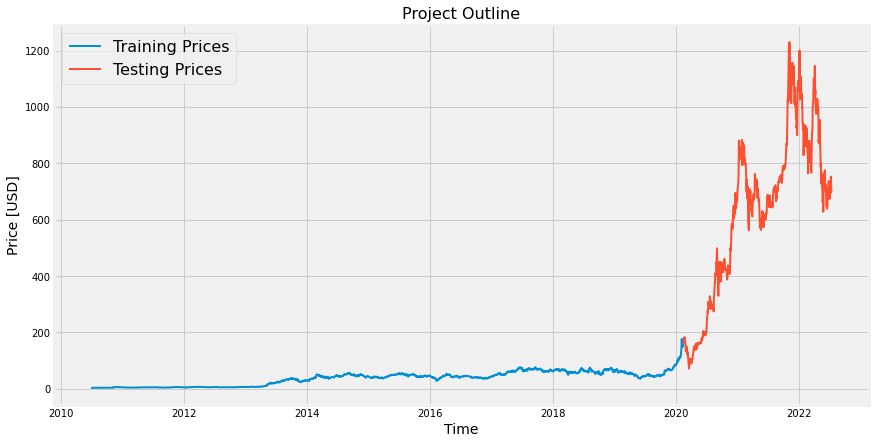

In [116]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Price [USD]', fontsize=14)
    ax.set_xlabel('Time', fontsize = 14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train["close"], test["close"], 'Training Prices', 'Testing Prices', title='Project Outline')

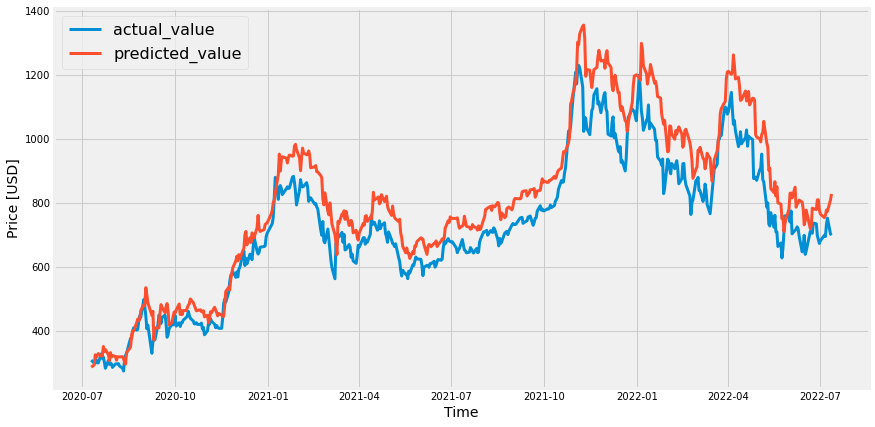

In [117]:
line_plot(targets, preds, 'actual_value', 'predicted_value', lw=3)

### Future Prediction for 30 days

In [138]:
len(test)

606

In [139]:
length = len(test_scaled)
length

606

In [140]:
#Getting the last 100 days records
fut_inp = test_scaled[length-100:]
fut_inp.shape

(100, 1)

In [141]:
fut_inp = fut_inp.reshape(1,-1)

In [142]:
fut_inp.shape

(1, 100)

In [143]:
fut_inp

array([[0.75013653, 0.71179128, 0.69600159, 0.66710414, 0.62024044,
        0.65018137, 0.65759933, 0.70696553, 0.70202565, 0.71467698,
        0.68158138, 0.68076622, 0.65328714, 0.66944365, 0.69762376,
        0.68077438, 0.64576316, 0.62213978, 0.65109435, 0.68234763,
        0.70791926, 0.73546362, 0.74831869, 0.80767879, 0.81186057,
        0.82393312, 0.82125941, 0.88745053, 0.89375171, 0.88920315,
        0.87584263, 0.8815406 , 0.93115135, 0.88697777, 0.8498879 ,
        0.85926226, 0.83336455, 0.79296512, 0.80194822, 0.83082125,
        0.80035865, 0.81608311, 0.83553291, 0.7940004 , 0.81974322,
        0.81670264, 0.81097207, 0.71184835, 0.71599754, 0.71273689,
        0.70723455, 0.73346646, 0.73861013, 0.7739637 , 0.70928878,
        0.70306909, 0.63904623, 0.64958627, 0.59575299, 0.59086202,
        0.62476463, 0.58790298, 0.6182596 , 0.57603422, 0.57571629,
        0.53861015, 0.54757694, 0.50947622, 0.5344528 , 0.57433867,
        0.6166456 , 0.61552883, 0.60094557, 0.62

In [144]:
tmp_inp = list(fut_inp)

In [145]:
tmp_inp

[array([0.75013653, 0.71179128, 0.69600159, 0.66710414, 0.62024044,
        0.65018137, 0.65759933, 0.70696553, 0.70202565, 0.71467698,
        0.68158138, 0.68076622, 0.65328714, 0.66944365, 0.69762376,
        0.68077438, 0.64576316, 0.62213978, 0.65109435, 0.68234763,
        0.70791926, 0.73546362, 0.74831869, 0.80767879, 0.81186057,
        0.82393312, 0.82125941, 0.88745053, 0.89375171, 0.88920315,
        0.87584263, 0.8815406 , 0.93115135, 0.88697777, 0.8498879 ,
        0.85926226, 0.83336455, 0.79296512, 0.80194822, 0.83082125,
        0.80035865, 0.81608311, 0.83553291, 0.7940004 , 0.81974322,
        0.81670264, 0.81097207, 0.71184835, 0.71599754, 0.71273689,
        0.70723455, 0.73346646, 0.73861013, 0.7739637 , 0.70928878,
        0.70306909, 0.63904623, 0.64958627, 0.59575299, 0.59086202,
        0.62476463, 0.58790298, 0.6182596 , 0.57603422, 0.57571629,
        0.53861015, 0.54757694, 0.50947622, 0.5344528 , 0.57433867,
        0.6166456 , 0.61552883, 0.60094557, 0.62

In [146]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [147]:
tmp_inp

[0.7501365310742678,
 0.7117912792330112,
 0.6960015947307486,
 0.6671041420977862,
 0.6202404376701245,
 0.6501813718311257,
 0.6575993255688796,
 0.7069655341048884,
 0.7020256540706158,
 0.7146769844719646,
 0.6815813774821546,
 0.6807662154912971,
 0.653287136570807,
 0.6694436529357375,
 0.6976237597560973,
 0.6807743752628256,
 0.6457631579735502,
 0.6221397789665764,
 0.6510943491850761,
 0.6823476313838847,
 0.7079192597764379,
 0.735463615238832,
 0.7483186855978519,
 0.8076787874782322,
 0.8118605725671414,
 0.8239331200214176,
 0.8212594147765885,
 0.8874505284912836,
 0.8937517143773727,
 0.8892031463355151,
 0.875842629893092,
 0.8815406040575664,
 0.9311513505937267,
 0.8869777704037137,
 0.8498878998196955,
 0.8592622627145573,
 0.8333645499617733,
 0.7929651241403594,
 0.8019482247676873,
 0.8308212486261077,
 0.8003586491035712,
 0.8160831059736495,
 0.835532908572962,
 0.7940003953568263,
 0.8197432248858614,
 0.8167026372383211,
 0.8109720745277763,
 0.71184834627850

In [148]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.6324378848075867], [0.6937312483787537], [0.7532308101654053], [0.8113888502120972], [0.869089663028717], [0.9277916550636292], [0.988536536693573], [1.0517632961273193], [1.117378830909729], [1.1849219799041748], [1.2537198066711426], [1.3229988813400269], [1.391958475112915], [1.4598139524459839], [1.525829553604126], [1.5893428325653076], [1.6497894525527954], [1.7067171335220337], [1.75979745388031], [1.8088253736495972], [1.8537132740020752], [1.89447820186615], [1.931226134300232], [1.964132308959961], [1.993424654006958], [2.0193634033203125], [2.0422282218933105], [2.0623064041137695], [2.0798802375793457], [2.095219612121582]]


In [149]:
end_date

'2022-07-12'

In [150]:
temp = pd.to_datetime(end_date, format='%Y-%m-%d')
temp
end_date_new = temp.strftime('%m/%d/%Y')
end_date_new

'07/12/2022'

In [151]:
preds = scaler.inverse_transform(lst_output)
preds

array([[ 779.00319669],
       [ 854.19483254],
       [ 927.18592198],
       [ 998.53129958],
       [1069.31577367],
       [1141.32844439],
       [1215.84723   ],
       [1293.41065928],
       [1373.90451881],
       [1456.76307913],
       [1541.16081546],
       [1626.14892267],
       [1710.74510667],
       [1793.9868158 ],
       [1874.97145676],
       [1952.88637389],
       [2027.03926701],
       [2096.87530158],
       [2161.99158638],
       [2222.13658862],
       [2277.20282191],
       [2327.21119855],
       [2372.29172591],
       [2412.6593768 ],
       [2448.59376208],
       [2480.41412368],
       [2508.46354064],
       [2533.09445136],
       [2554.65315217],
       [2573.47073041]])

In [152]:
import datetime
date_future = temp + datetime.timedelta(41)
date_future_str = date_future.strftime('%m/%d/%Y')
date_future_str

'08/22/2022'

In [153]:
c = pd.date_range(start=end_date_new, end=date_future_str, freq='B')
c

DatetimeIndex(['2022-07-12', '2022-07-13', '2022-07-14', '2022-07-15',
               '2022-07-18', '2022-07-19', '2022-07-20', '2022-07-21',
               '2022-07-22', '2022-07-25', '2022-07-26', '2022-07-27',
               '2022-07-28', '2022-07-29', '2022-08-01', '2022-08-02',
               '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-08',
               '2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12',
               '2022-08-15', '2022-08-16', '2022-08-17', '2022-08-18',
               '2022-08-19', '2022-08-22'],
              dtype='datetime64[ns]', freq='B')

In [154]:
len(c)

30

In [155]:
fut_preds = pd.Series(index=c, data=preds.squeeze())
fut_preds

2022-07-12     779.003197
2022-07-13     854.194833
2022-07-14     927.185922
2022-07-15     998.531300
2022-07-18    1069.315774
2022-07-19    1141.328444
2022-07-20    1215.847230
2022-07-21    1293.410659
2022-07-22    1373.904519
2022-07-25    1456.763079
2022-07-26    1541.160815
2022-07-27    1626.148923
2022-07-28    1710.745107
2022-07-29    1793.986816
2022-08-01    1874.971457
2022-08-02    1952.886374
2022-08-03    2027.039267
2022-08-04    2096.875302
2022-08-05    2161.991586
2022-08-08    2222.136589
2022-08-09    2277.202822
2022-08-10    2327.211199
2022-08-11    2372.291726
2022-08-12    2412.659377
2022-08-15    2448.593762
2022-08-16    2480.414124
2022-08-17    2508.463541
2022-08-18    2533.094451
2022-08-19    2554.653152
2022-08-22    2573.470730
Freq: B, dtype: float64

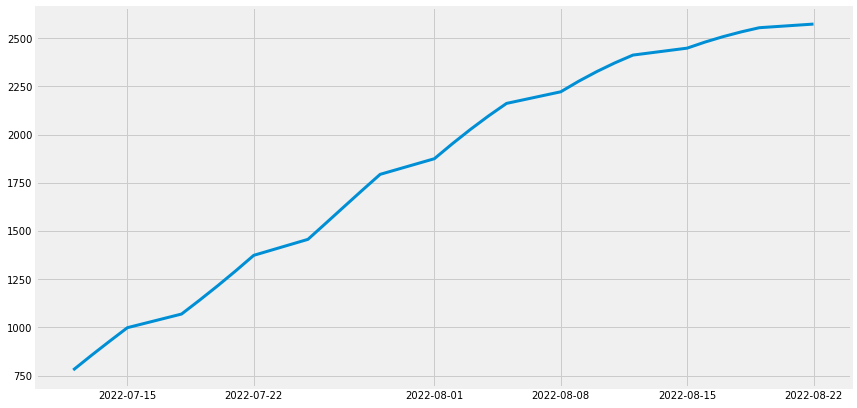

In [156]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(fut_preds, label="predicted value_30", linewidth=3)

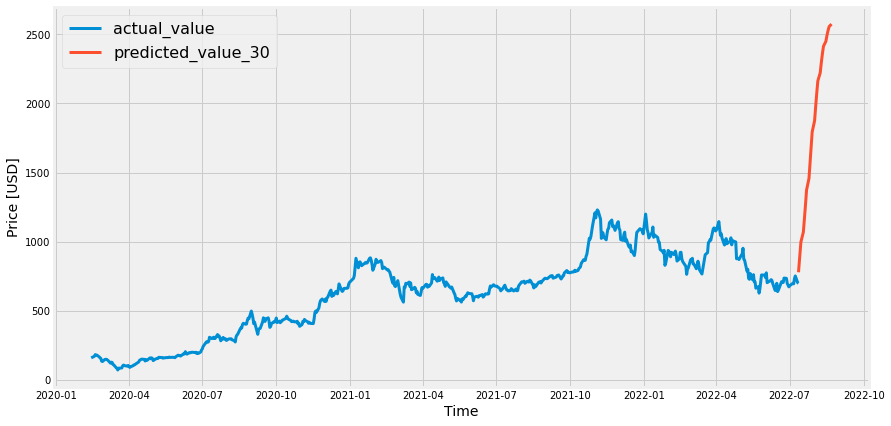

In [157]:
line_plot(test["close"], fut_preds, 'actual_value', 'predicted_value_30', lw=3)